In [22]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import time
import cv2

# Image compression using clustering

In this programming assignment, you are going to apply clustering algorithms for image compression. Your
task is implementing the clustering parts with two algorithms: K-means and K-medoids. It is required
you implementing the algorithms yourself rather than calling from a package.

## K-medoids

In class, we learned that the basic K-means works in Euclidean space for computing distance between data
points as well as for updating centroids by arithmetic mean. Sometimes, however, the dataset may work
better with other distance measures. It is sometimes even impossible to compute arithmetic mean if a feature
is categorical, e.g, gender or nationality of a person. With K-medoids, you choose a representative data point
for each cluster instead of computing their average. Please note that K-medoid is different from generalized
K-means: Generalized K-means still computes centre of a cluster is not necessarily one of the input data
points (it is a point that minimizes the overall distance to all points in a cluster in a chosen distance metric).
Given m data points $x^i(i=1, ... ,m)$, K-medoids clustering algorithm groups them into K clusters by minimizing teh distortion function $J = \sum_{i=1}^m \sum_{j=1}^k r^{ij} D(x^i, \mu^j)$ where D(x,y) is a distance measure between two vectors x and y in same size (in case of K-means, D(x,y) = $||x-y||^2),\mu^j$ is the center of j-th cluster and $r^{ij}=1$ if $x^n$ belongs to the k-th cluster and $r^{ij}=0$ otherwise. In this exercise, we will use the following iterative procedure.

* Initialize the cluster center $\mu^j$, j=1, ..., k
* Iterate until convergence:
 * Update the cluster assignments for every data point $x^i : r^{ij} = 1$ if j = $argmin_j D(x^i , μ^j )$, and
$r^{ij} = 0$ otherwise.
 * Update the center for each cluster j: choosing another representative if necessary.
 
There can be many options to implement the procedure; for example, you can try many distance measures
in addition to Euclidean distance, and also you can be creative for deciding a better representative of each
cluster. We will not restrict these choices in this assignment. You are encouraged to try many distance
measures as well as way of choosing representatives (e.g., $ℓ_1$ norm).

In [66]:
class Distances:
    '''
    This class is responsible for all distance calculations. Supported distance metrics are from the set
    {eucl, eucl_squared, manhattan, minkowski}. Each method underneath calls the minkowski methods since
    each metric is a variant of the minkowski distance with respect to a different power, p.
    '''
    def __init__(self, distance: str) -> None:
        '''
        inputs
        ------
        distance (str) -> The distance metric desired from the set {eucl, eucl_squared, manhattan, minkowski}
        '''
        assert distance in ('eucl', 'eucl_squared', 'manhattan', 'minkowski'), 'Distance "{}" not understood. Please choose from ("eucl" | "eucl_squared" | "manhattan" | "minkowski")'.format(distance)
        self.distance = distance
        
    def _calculate_distance(self, p1: np.array, p2: np.array, p=None) -> np.array:
        '''
        This method is the main callable method for this class. Underneath, it will call the relevant
        distance metric as dictated by distance from class instantiation
        '''
        if self.distance == 'eucl':
            return self._euclidean(p1, p2)
        
        elif self.distance == 'eucl_squared':
            return self._euclidean(p1, p2)**2
        
        elif self.distance == 'manhattan':
            return self._manhattan(p1, p2)
        
        elif self.distance == 'minkowski' or (p>2 or p<1):
            return self._minkowski(p1, p2, p)
        
    def _euclidean(self, p1: np.array, p2:np.array) -> np.array:
        '''
        Euclidean distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        eucl: array -> euclidean distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        eucl = self._minkowski(p1, p2, 2)
        
        return eucl
    
    def _manhattan(self, p1: np.array, p2: np.array) -> np.array:
        '''
        Manhattan Distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        manhan: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for manhattan distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 manhattan distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        manhan = self._minkowski(p1, p2, 1)
        return manhan
    
    def _minkowski(self, p1: np.array, p2: np.array, p: int) -> np.array:
        '''
        Minkowski Distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        mink: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for minkowski distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 minkowski distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        mink = np.sum(np.abs(p1-p2)**p, axis=1)**(1/p)
        return mink

    
  


    
class RandomInit:
    def __init__(self, method: str)-> None:
        '''
        This class is responsible for randomly initializing centroids for either kmeans or kmedoids algorithms
        
        inputs
        ------
        method: (str) -> type of initialization need (kmedoids | kmeans)
        '''
        assert method in ('kmedoids', 'kmeans'), 'RandomInit method "{}" not understood. Please choose (kmedoids | kmeans)'.format(method)
        self.method = method
        
        
    def _initialize(self, x: np.array, k: int):
        '''
        This is the main callable method for this class to randomly intialize cluster
        centroids. Underneath it will call the proper method to initialize based off of 
        the given method during class instantiation
        '''
        if self.method == 'kmedoids' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no data given')
        elif self.method == 'kmedoids' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no k given')
        
        if self.method == 'kmeans' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no k given')
        elif self.method == 'kmeans' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no data given')
            
        if self.method == 'kmedoids':
            return self._kmedoids_init(x=x, k=k)
        
        elif self.method == 'kmeans':
            return self._kmeans_init(k=k, x=x)

    def _kmedoids_init(self, x: np.array, k: int)->list:
        '''
        initializes k kmedoid cluster centers by randomly selecting k data points from
        the input data
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> The number of desired cluster centers
        
        outputs
        -------
        clusters: np.array -> k randomly selected data points to be the cluster centroids
        
        '''
        #holds the randomly selected data point indices
        cluster_idxs = []
        
        for i in range(k):
            #random select a datapoint index
            rand_cluster = np.random.randint(0, len(x))
            #if this point has been previously selected, select another one
            while rand_cluster in cluster_idxs:
                rand_cluster = np.random.randint(0, len(x))
            #add new data point index
            cluster_idxs.append(rand_cluster)
        #return data points located at the randomly chosen indices
        return x[cluster_idxs]
    
    def _kmeans_init(self, x: np.array, k: int) -> np.array:
        '''
        initializes k random cluster centroids by randomly selecting k values for 
        each dimension's domain in x
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> the number of desired cluster centers
        
        outputs
        -------
        rand_centroids: np.array -> k randomly initialized centroids of shape (k,n)
        '''
        #get the min value for each column in x
        min_domain = np.min(x, axis=0)
        #get the max value for each column in x
        max_domain = np.max(x, axis=0)
        #get the shape of x
        m,n = x.shape
        
        #randomly generated k cluster centroids between the low and hi domains for each column
        rand_centroids = np.random.uniform(low=min_domain, high=max_domain, size=(k,n))
        
        return rand_centroids
    
    
    
class uniformInit:
    '''
    This class is responsible for creatting a uniform intialization of cluster centers for Kmedoids.
    It sorts the input x and then selects k equally spaced points from the sorted array. It returns
    the equidistant clusters as centers for the Kmedoids algorithm
    '''
    def _initialize(self, x, k):
        '''
        inputs
        ------
        x: np.array -> data points to be clustered
        k: int -> number of clusters
        
        outputs
        -------
        cluster_centers: np.array -> k equally distant points
        '''
        #sort the points
        x = np.sort(x)
        
        #get total points
        m = x.shape[0]
        
        #list to store the index positions
        idxs = []
        #get an index for each cluster
        for i in range(1, k+1):
            
            frac = i / k
            idx = int(frac * m) - 1
            idxs.append(idx)
            
        #return cluster centers
        return x[idxs]
        

class badInit:
    '''
    This class is responsible for performing a bad intialization of cluster centers.
    It does so by first sorting the data points then selecting the midpoint. It then 
    selects midpoint + i for i in range(k) clusters. E.g. if x has 20 points and k=3,
    this initializer will return data points at index positions x[10], x[11], x[12]
    '''
    def _initialize(self, x, k):
        #sort data points
        x = np.sort(x)
        #get total number of points
        m = x.shape[0]
        #get midpoint index
        idx = m//2
        #return indices of midpoint + i in range(k)
        idxs = [idx + x for x in range(k)]
        
        return x[idxs]
        



        
class KMedoids:
    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, initializer='uniform',verbose=True) -> None:
        '''
        This class is the main driver for a KMedoids implementation. The initializer calls the 
        RandomInit Class and passes the proper arguments for KMedoids initialization. The distance
        metric is called from the Distances class. The distance metric is pass forward as a parameter
        to the Distance class
        '''

        self.k = k
        self.distance = Distances(distance=distance_metric)
        if initializer == 'uniform':
            self.initializer = uniformInit()
        elif initializer == 'random':
            self.initializer = RandomInit(method='kmedoids')
        elif initializer == 'bad':
            self.initializer = badInit()
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
       
        m,n = x.shape
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
   
        #classify each cluster centroid point as their own cluster
        self._classify_centroids_as_themselves(x)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                

            
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
     
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
  
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True
            
            
            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}

    def _assign(self, x):

        
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)

                
            #if data point is already a centroid then skip it
            if (current_data_point == self.cluster_centers).all(axis=1).any():
                continue
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment

            
    def _update_centroids(self, x):
        centroid_costs = {c:np.inf for c in range(self.k)}
        
        #for each cluster
        for c in range(self.k):
            
            #get all data points that exist in cluster c
            cx = x[(self.cluster_assignments == c).ravel()]
            
            #if a cluster has no points - continue
            if not cx.any().any(): continue
    
            else:
                #randomly select 35% of the points in the cluster to swap with centroid
                idxs = np.random.randint(low=0, high=cx.shape[0], size=int(0.35 * len(cx)))
                current_medoid = self.cluster_centers[c]
                cx = np.append(cx[idxs], current_medoid.reshape(1,-1), axis=0)


                #for each point in the cluster  calculate their distance from all other points in cluster
                for pos, point in enumerate(cx):

                    #distance of current point from all other points
                    distance = self.distance._calculate_distance(point.reshape(1,-1), cx, self.p)
              
                    #cost is the sum of distances
                    cost = np.sum(distance)

                    #check if this cost is lower than the current cost for the centroid
                    #if it is then make this point the new centroid
                    old_cost = centroid_costs[c]
                    
                    if cost < old_cost:
                   
                        #update the cost value for this point
                        centroid_costs[c] = cost

                        #update this point as the new center for centroid c
                        self.cluster_centers[c] = point
     
    def _classify_centroids_as_themselves(self, x):
        #after random initializing centroids, need to classify these points
        #as their own cluster number
        for pos, point in enumerate(self.cluster_centers):
            idx = np.argwhere((x == point).all(axis=1))
            self.cluster_assignments[idx] = pos
                    

                
                
                
class KMeans:

    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, initializer='random', verbose=True) -> None:
        '''
        This class is the main driver for a KMeans implementation. The initializer calls the 
        RandomInit Class and passes the proper arguments for Kmeans initialization. The distance
        metric is called from the Distances class. The distance metric is pass forward as a parameter
        to the Distance class
        '''

        self.k = k
        self.distance = Distances(distance=distance_metric)
        if initializer=='random':
            self.initializer = RandomInit(method='kmeans')
        elif initializer=='bad':
            self.initializer = badInit()
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
        m,n = x.shape
        
        #initialize dict to accumulate cost for each centroid
        self.centroid_costs = {c:0 for c in range(self.k)}
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
            
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
            
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True

            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}
            
            
            
    def _assign(self, x):
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment
            
            #update the cost for the current centroid
            self.centroid_costs[assignment] += cost
            
    def _update_centroids(self, x):

            #for each cluster
            for pos, c in enumerate(range(self.k)):

                #get all data points that exist in cluster c
                cx = x[(self.cluster_assignments == c).ravel()]
                
                #if a cluster has been assigned points
                if cx.any().any():
                    #calculate the positional mean
                    cluster_mean = np.mean(cx, axis=0)

                    #update the cluster centroid with the mean
                    self.cluster_centers[pos] = cluster_mean

        
        
class KMClustering:
    def __init__(self, algorithm='kmedoids', k=3, distance_metric='eucl', iterations=1000, initializer='random', verbose=True, p=None) -> None:
        '''
        This class is the main class for implementing either a Kmeans or Kmedoids algorithm. It is a wrapper around the base
        classes for each method so that only one API needs to be called.
        
        inputs
        ------
        algorithm: str -> Either kmedoids or kmeans
        k: int -> Number of clusters
        distance_metric: string -> Distance metric chosen from the set of {eucl | eucl_squared | manhattan | minkowski}
        iteration: int -> Number iterations the algorithm should run for
        verbose: bool -> Flag for logging to std out while training
        p: int -> Exponent desired for minkowski distance metric
        '''
        assert algorithm in ('kmedoids','kmeans'), 'Unrecognized algorithm {}. Please choose from either (kmedoids | kmeans)'.format(algorithm)
        assert isinstance(iterations, int), 'iterations must be of type int only'
        assert isinstance(verbose, bool), 'verbose parameter can only be True or False'
        
        self.algorithm = algorithm
        self.k = k
        self.distance_metric = distance_metric
        self.iterations = iterations
        self.initializer=initializer
        self.p = p
        self.verbose = verbose
        if verbose: print(self.__repr__())
        
    def __repr__(self):
        instance = '''k: {} \nAlgorithm: {} \nDistance Metric: {} \nInitializer: {} \nIterations: {} \np: {}
                   '''.format(self.k, self.algorithm, self.distance_metric, self.initializer, self.iterations,self.p)
        return instance
        
        
    def fit(self, x: np.array) -> None:
        
        if self.algorithm == 'kmedoids':
            self.cluster_model = KMedoids(k=self.k,
                                     distance_metric=self.distance_metric,
                                     p=self.p,
                                     iterations=self.iterations,
                                     initializer=self.initializer,
                                     verbose=self.verbose)
            self.cluster_model.fit(x)
            
        if self.algorithm == 'kmeans':
            self.cluster_model = KMeans(k=self.k,
                                   distance_metric=self.distance_metric,
                                   p=self.p,
                                   iterations=self.iterations,
                                   initializer=self.initializer,
                                   verbose=self.verbose)
            
            self.cluster_model.fit(x)
            
    def cluster_centers(self):
        return self.cluster_model.cluster_centers
    
    def clusters(self):
        return self.cluster_model.cluster_assignments.ravel()
        
        
        

def reproduce(model, x, shape):
    cc = model.cluster_centers()
    c = model.clusters()
    temp_x = x.copy()
    
    for pos, i in enumerate(cc):
        temp_x[c == pos] = i
        
    return temp_x.reshape(shape)

## Within the k-medoids framework, you have several choices for detailed implementation. Explain how you designed and implemented details of your K-medoids algorithm, including (but not limited to) how you chose representatives of each cluster, what distance measures you tried and chose one, or when you stopped iteration. {-}

### **Answer** {-}

I created a separate classs for each of the 3 main features of the kmedoids algorithm
* **Distance** - This class houses the different implementations for the following distance metrics **{euclidean | euclidean squared | manhattan | minkowski}**. Since Euclidean and manhattan are just the minkowski distance where p = 2 and 1 respectively, the methods for these metrics internally call the minkowski method with the proper exponent
* **Initialization** - There's three different classes for intialization **{Random | Uniform | Bad}**. The random intialization class takes in k (the amount of clusters) and x (the points to be classified). It then randomly selects k points out of x to serve as the cluster centroids for k clusters. The uniform intialization class takes in k (the amount of clusters) and x (the points to be classified). It then sorts the input x. After sorting x, it selects $\sum_i^k (\frac{i}{k}) * m$ index positions where m is the number of data points in x. e.g. If m = 20 and k = 3, uniform initialization will select the points of x at index locations (1/3)\*20 , (2/3)\*20 , (3/3)\*20 = x[6], x[13], x[20]. The bad initializer first sorts the input data points. It then finds the midpoint index and returns data points at indices midpoint + i for i in range(k). E.g if x has 20 data points and k=3, x is first sorted, then datapoints x[10], x[11], x[12] are returned as the cluster centers
* **Kmedoids** - This class makes use of the distance and intialization classes to perform the kmedoids algorithm. First the algorithm initializes the clusters per the user defined initialization **(random | uniform | bad)**. It then assigns each point in X to a cluster. Next the algorithm updates the cluster centers by selecting 35% of the points in each cluster and takes turns swapping the subset of points as the cluster center. It then calculates the distance of that point from all the other subselected points by using the Distance class and using the user specified distance metric **{euclidean | euclidean squared | manhattan | minkowski}**. The point with the smallest distance is selected to be the new cluster center. The algorithm then repeats this process until convergence (new clusters = old clusters) or total iterations is achieved. In traditional Kmedoids, the subselected points in a cluster has its distance calculated from all other points in the cluster. In my implementation, the subselected points only have their distances calculated from other subselected points instead of every point in a cluster. This method greatly speeds up runtime and still produces great results. E.g. If cluster 1 has 1000 points, 350 points are randomly selected to be tried out as new cluster center. Each point of the 350 has its distance calculated only from the points of the subselected 350 points, not the full 1000 points in the cluster

## Attach a picture of your own. We recommend size of 320 × 240 or smaller. Run your k-medoids implementation with the picture you chose, as well as two pictures provided (beach.bmp and football.bmp), with several different K. (e.g, small values like 2 or 3, large values like 16 or 32) What did you observe with different K? How long does it take to converge for each K? Please write in your report. {-}

In [3]:
football = plt.imread('football.bmp').astype(int)
beach = plt.imread('beach.bmp').astype(int)
myimage = plt.imread('custom.jpg').astype(int)

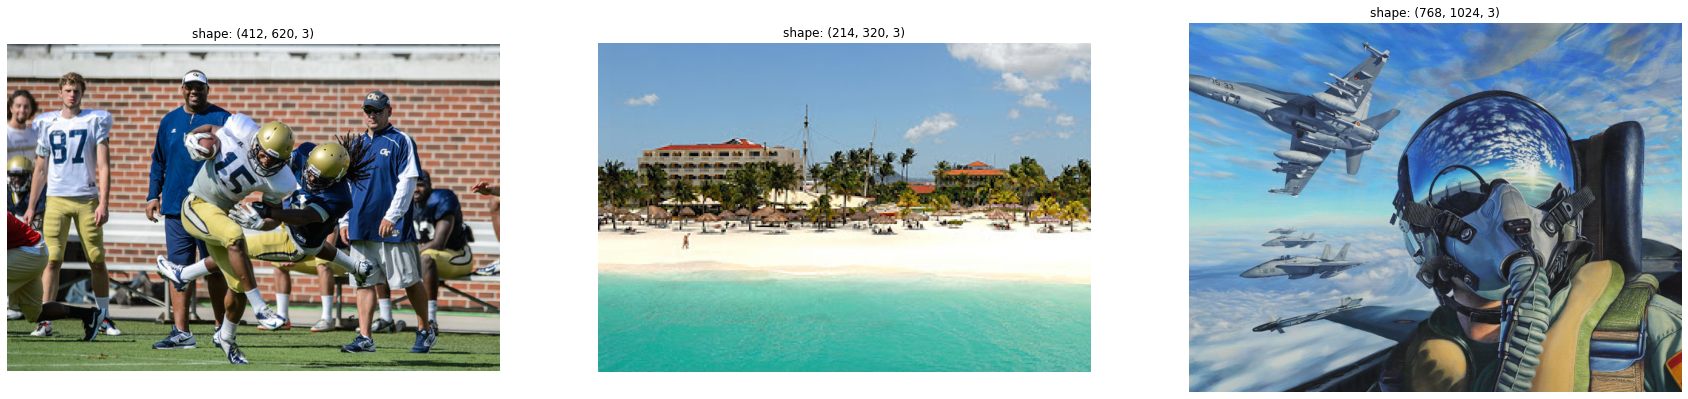

In [4]:
plt.subplots(nrows=1, ncols=3, figsize=(30,15))
plt.subplot(131)
plt.imshow(football)
plt.axis('off')
plt.title('shape: {}'.format(football.shape))
plt.subplot(132)
plt.imshow(beach)
plt.axis('off')
plt.title('shape: {}'.format(beach.shape))
plt.subplot(133)
plt.imshow(myimage)
plt.axis('off')
plt.title('shape: {}'.format(myimage.shape))
plt.show()

### Football Image {-}

In [5]:
X = football.reshape(-1, 3)

In [20]:
km_football_k_2 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=2, initializer='uniform', iterations=2, verbose=True)
km_football_k_32 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=32, initializer='uniform', iterations=2, verbose=True)
km_football_k_256 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=256, initializer='uniform', iterations=2, verbose=True)

k: 2 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   
k: 32 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   
k: 256 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   


In [21]:
#k=2
print('k=2')
tick = time.time()
km_football_k_2.fit(X)
time_football_2 = time.time() - tick

#k=32
print('\nk=32')
tick = time.time()
km_football_k_32.fit(X)
time_football_32 = time.time() - tick

#k=256
print('\nk=256')
tick=time.time()
km_football_k_256.fit(X)
time_football_256 = time.time() - tick

Iteration 0
Iteration 1
Iteration 0
Iteration 1
Iteration 0
Iteration 1


In [23]:
football_compressed_2 = reproduce(km_football_k_2, X, football.shape)
football_compressed_32 = reproduce(km_football_k_32, X, football.shape)
football_compressed_256 = reproduce(km_football_k_256, X, football.shape)

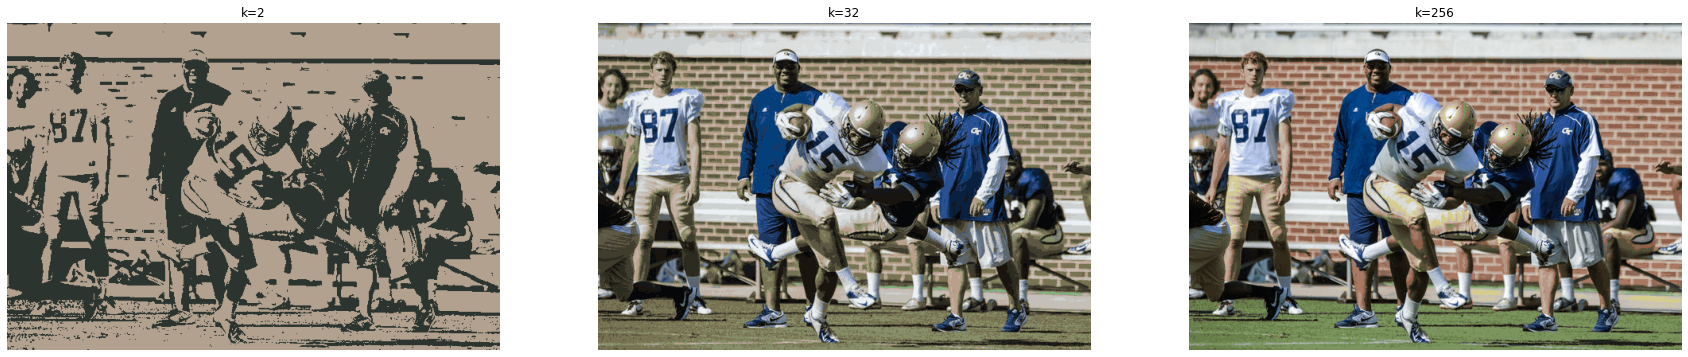

In [55]:
plt.subplots(nrows=1, ncols=3, figsize=(30,20))
plt.subplot(131)
plt.imshow(football_compressed_2)
plt.axis('off')
plt.title('k=2')
plt.subplot(132)
plt.imshow(football_compressed_32)
plt.axis('off')
plt.title('k=32')
plt.subplot(133)
plt.imshow(football_compressed_256)
plt.axis('off')
plt.title('k=256')
plt.show()

### Beach Image {-}

In [27]:
X = beach.reshape(-1, 3)

In [35]:
km_beach_k_2 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=2, initializer='uniform', iterations=5, verbose=True)
km_beach_k_32 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=32, initializer='uniform', iterations=5, verbose=True)
km_beach_k_256 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=256, initializer='uniform', iterations=5, verbose=True)

k: 2 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 5 
p: None
                   
k: 32 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 5 
p: None
                   
k: 256 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 5 
p: None
                   


In [36]:
#k=2
print('k=2')
tick = time.time()
km_beach_k_2.fit(X)
time_beach_2 = time.time() - tick

#k=32
print('\nk=32')
tick = time.time()
km_beach_k_32.fit(X)
time_beach_32 = time.time() - tick

#k=256
print('\nk=256')
tick=time.time()
km_beach_k_256.fit(X)
time_beach_256 = time.time() - tick

k=2
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

k=32
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

k=256
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [37]:
beach_compressed_2 = reproduce(km_beach_k_2, X, beach.shape)
beach_compressed_32 = reproduce(km_beach_k_32, X, beach.shape)
beach_compressed_256 = reproduce(km_beach_k_256, X, beach.shape)

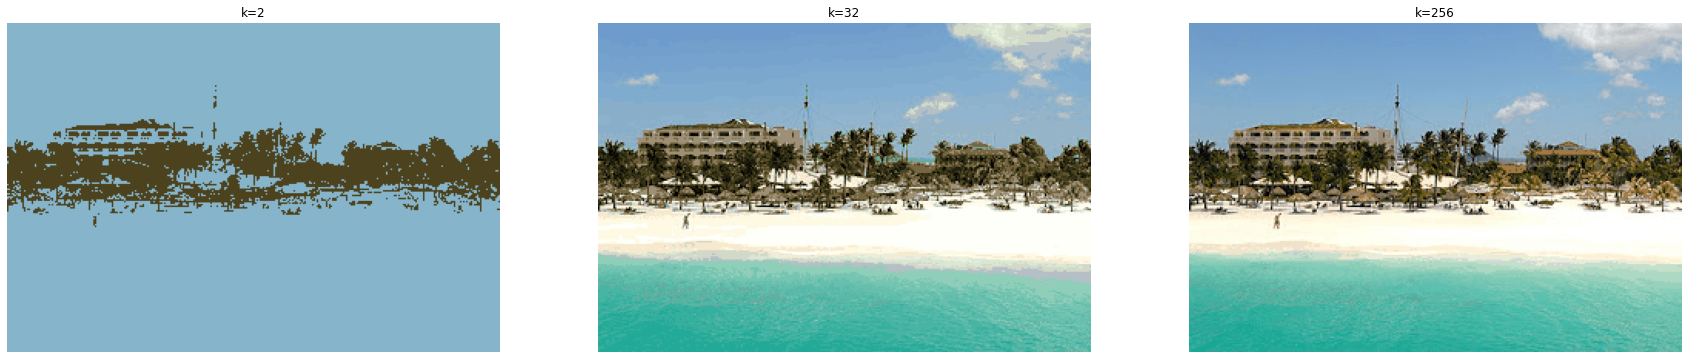

In [56]:
plt.subplots(nrows=1, ncols=3, figsize=(30,20))
plt.subplot(131)
plt.imshow(beach_compressed_2)
plt.axis('off')
plt.title('k=2')
plt.subplot(132)
plt.imshow(beach_compressed_32)
plt.axis('off')
plt.title('k=32')
plt.subplot(133)
plt.imshow(beach_compressed_256)
plt.axis('off')
plt.title('k=256')
plt.show()

### My Image

In [41]:
X = myimage.reshape(-1, 3)

In [42]:
km_myimage_k_2 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=2, initializer='uniform', iterations=2, verbose=True)
km_myimage_k_32 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=32, initializer='uniform', iterations=2, verbose=True)
km_myimage_k_256 = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=256, initializer='uniform', iterations=2, verbose=True)

k: 2 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   
k: 32 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   
k: 256 
Algorithm: kmedoids 
Distance Metric: manhattan 
Initializer: uniform 
Iterations: 2 
p: None
                   


In [43]:
#k=2
print('k=2')
tick = time.time()
km_myimage_k_2.fit(X)
time_myimage_2 = time.time() - tick

#k=32
print('\nk=32')
tick = time.time()
km_myimage_k_32.fit(X)
time_myimage_32 = time.time() - tick

#k=256
print('\nk=256')
tick=time.time()
km_myimage_k_256.fit(X)
time_myimage_256 = time.time() - tick

k=2
Iteration 0
Iteration 1

k=32
Iteration 0
Iteration 1

k=256
Iteration 0
Iteration 1


In [44]:
myimage_compressed_2 = reproduce(km_myimage_k_2, X, myimage.shape)
myimage_compressed_32 = reproduce(km_myimage_k_32, X, myimage.shape)
myimage_compressed_256 = reproduce(km_myimage_k_256, X, myimage.shape)

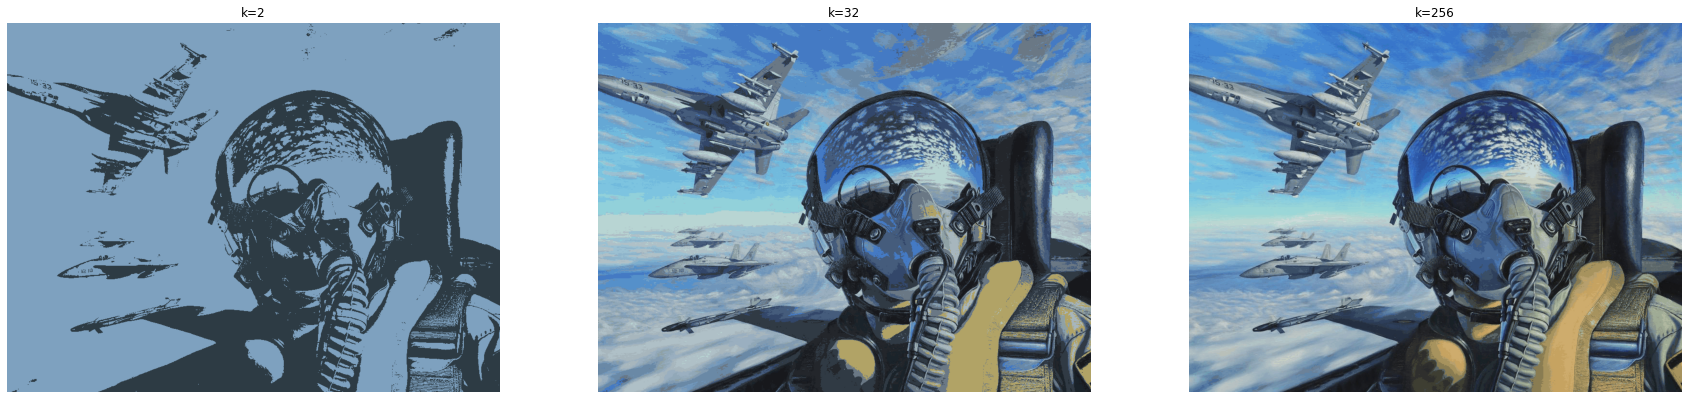

In [57]:
plt.subplots(nrows=1, ncols=3, figsize=(30,20))
plt.subplot(131)
plt.imshow(myimage_compressed_2)
plt.axis('off')
plt.title('k=2')
plt.subplot(132)
plt.imshow(myimage_compressed_32)
plt.axis('off')
plt.title('k=32')
plt.subplot(133)
plt.imshow(myimage_compressed_256)
plt.axis('off')
plt.title('k=256')
plt.show()

In [64]:
time_string = '''

Football k=2 runtime:   {} seconds
Football k=32 runtime:  {} seconds
Football k=256 runtime: {} seconds

Beach k=2 runtime:      {} seconds
Beach k=32 runtime:     {} seconds
Beach k=256 runtime:    {} seconds

My Image k=2 runtime:   {} seconds
My Image k=32 runtime:  {} seconds
My Image k=256 runtime: {} seconds
'''.format(time_football_2, time_football_32, time_football_256, time_beach_2, time_beach_32, time_beach_256, time_myimage_2, time_myimage_32, time_myimage_256  )

print(time_string)



Football k=2 runtime:   271.12459421157837 seconds
Football k=32 runtime:  44.42675518989563 seconds
Football k=256 runtime: 36.232136249542236 seconds

Beach k=2 runtime:      66.09342169761658 seconds
Beach k=32 runtime:     13.027208089828491 seconds
Beach k=256 runtime:    13.385507583618164 seconds

My Image k=2 runtime:   2764.3635289669037 seconds
My Image k=32 runtime:  303.37619805336 seconds
My Image k=256 runtime: 117.64475512504578 seconds



In [65]:
print('Total football data points: ', football.reshape(-1,3).shape[0])
print('Total beach data points: ', beach.reshape(-1,3).shape[0])
print('Total myimage data points: ', myimage.reshape(-1,3).shape[0])

Total football data points:  255440
Total beach data points:  68480
Total myimage data points:  786432


### Results {-}
For each image, I tried out k=2, 32, 256 with manhattan distance. I utilized the uniform initialization to avoid the initialization of clusters very close to each other in order to facilitate faster convergence. By using this intialization and my implementation of cluster updates, I only needed 2 iterations for the football and custom image, and 5 iterations for the beach image. when k=2 for all 3 images, the pixels are grouped correctly into one of two clusters such that the image is still visually relevant. as k increased >> 2, kmedoids does a very good job of replicating the original image. Runtime was the highest for all 3 images when k=2 due to the amount of points in each cluster and having to iterate through each one. When k >> 2, there was far fewer points to iterate through during the update step since only 35% of the points were being sample. Overall the fastest k=22 was 66 seconds with the beach image since it had the fewest number of data points, 68,480. The longest k=2 runtime was my custom image at 40 minutes. This is because this is a full size 4k image that I didn't downsample. Because of this, there were 786,432 data points. This ordering of runtime (as seen above) holds true for both k=32 and k=256. 

## Run your k-medoids implementation with different initial centroids/representatives. Does it affect final result? Do you see same or different result for each trial with different initial assignments? (We usually randomize initial location of centroids in general. To answer this question, an intentional poor assignment may be useful.) Please write in your report. {-}

For this section, I will run the analysis on k=10. This is because k is large enough that runtime won't take a substantial amount of time. Also k is small enough that any variance in the intializations of clusters should reveal a difference in the final image. For the initializations, I will use all 3 methods, random, uniform, and bad

In [67]:
X = football.reshape(-1, 3)
km_football_rand = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='random', iterations=2, verbose=False)
km_football_uniform = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='uniform', iterations=2, verbose=False)
km_football_bad = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='bad', iterations=2, verbose=False)

km_football_rand.fit(X)
km_football_uniform.fit(X)
km_football_bad.fit(X)

In [68]:
X = beach.reshape(-1, 3)
km_beach_rand = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='random', iterations=2, verbose=False)
km_beach_uniform = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='uniform', iterations=2, verbose=False)
km_beach_bad = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='bad', iterations=2, verbose=False)

km_beach_rand.fit(X)
km_beach_uniform.fit(X)
km_beach_bad.fit(X)

In [ ]:
X = myimage.reshape(-1, 3)
km_myimage_rand = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='random', iterations=2, verbose=False)
km_myimage_uniform = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='uniform', iterations=2, verbose=False)
km_myimage_bad = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=10, initializer='bad', iterations=2, verbose=False)

km_myimage_rand.fit(X)
km_myimage_uniform.fit(X)
km_myimage_bad.fit(X)

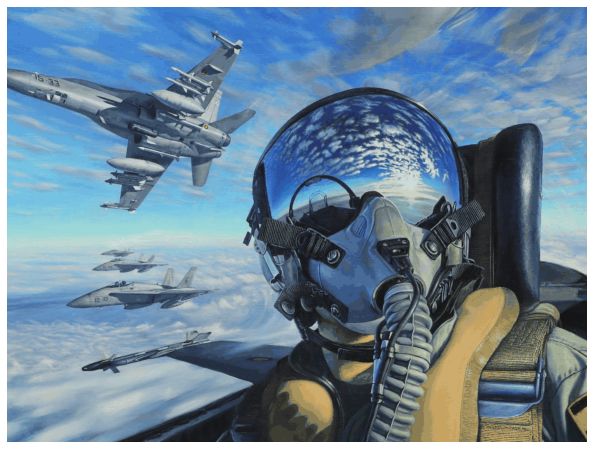

In [48]:
plt.figure(figsize=(15,8))
plt.imshow(myimage_compressed_256)
plt.axis('off')
plt.show()

In [63]:
time_myimage_256

117.64475512504578